# Alternating Least Squares

Common steps for Recommendation Systems

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('/opt/datasetsRepo/RecommendationData/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
idx_to_userid_mapper = dict(enumerate(ratings.userId.unique()))
userid_to_idx_mapper = dict(zip(idx_to_userid_mapper.values(), idx_to_userid_mapper.keys()))

In [4]:
idx_to_movieid_mapper = dict(enumerate(ratings.movieId.unique()))
movieid_to_idx_mapper = dict(zip(idx_to_movieid_mapper.values(), idx_to_movieid_mapper.keys()))

In [5]:
len(idx_to_userid_mapper), len(userid_to_idx_mapper)

(610, 610)

In [6]:
len(idx_to_movieid_mapper), len(movieid_to_idx_mapper)

(9724, 9724)

In [7]:
ratings['user_idx'] = ratings['userId'].map(userid_to_idx_mapper).apply(np.int32)
ratings['movie_idx'] = ratings['movieId'].map(movieid_to_idx_mapper).apply(np.int32)
ratings.head(10)

,userId,movieId,rating,timestamp,user_idx,movie_idx
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
5,1,70,3.0,964982400,0,5
6,1,101,5.0,964980868,0,6
7,1,110,4.0,964982176,0,7
8,1,151,5.0,964984041,0,8
9,1,157,5.0,964984100,0,9


## References

- http://cs229.stanford.edu/proj2017/final-posters/5147271.pdf
- https://nightlies.apache.org/flink/flink-docs-release-1.2/dev/libs/ml/als.html
- 

## Intro 

ALS algorithm works by alternating between rows and columns to factorized the matrix.

> Stochastic Gradient Descent 

- Flexibility - Already using it for a lot of different problems and algorithms
- Parallel - scaling matrix factorization
- Slower - iterative
- Hard to handle unobserved interaction (sparsity)


> Alternating Least Square 

- only works for least square problems only
- Parallel
- Faster
- Easy to handle sparsity

## Approach


```sql
    
              movies (n)                         k                  n
            +---------------------+        +------+   +----------------------+
            |                     |        |      | x |      movie           | k
            |                     |        | user |   |      factor          |      V
            |                     |        |factor|   +----------------------+
  users(m)  |                     |        |      |
            |     RATINGS         |    ~   |      |
            |                     |    ~   |      | m
            |                     |        |      |
            |                     |        |      |
            |                     |        |      |
            +---------------------+        +------+
                                                U
```

Iterative Algorithm 

* fix V, compute U
* fix U, compute V

## Compare with SVD


Matrix Factorization Method.

More here https://machinelearningexploration.readthedocs.io/en/latest/MathExploration/SingularValueDecomposition.html

```sql

                                        +----------------------+
                                      K |______________________| 
                                        |                      |  
  items                            K    +----------------------+        
+---------------------+        +-------+   
|                     |        |   |   |   
|u                    |        |   |   |   
|s                    |        |   |   |
|e                    |    ~   |   |   |
|r                    |    ~   |   |   | 
|s                    |        |   |   |
|                     |        |   |   |
|                     |        |   |   |
+---------------------+        +-------+
           X                      V       x       VT             


                 row factors (items embeddings)
               /
Factorization 
               \ 
                column factors (user embeddings)
                
                
```


In `SVD` the missing observations has to be fill as zeros.

$| A - U V^T |^2$

```sql
        item1  item2  item3   item4
       +------+------+------+------+
 user1 |  1   |  0   |  0   |  1   |
       +------+------+------+------+
 user2 |  0   |  1   |  0   |  0   |
       +------+------+------+------+
 user3 |  0   |  1   |  0   |  0   |
       +------+------+------+------+
 user4 |  0   |  0   |  1   |  0   |
       +------+------+------+------+
   
```
This leads to a large assumption for business and it impacts results heavily due to large percentage of assumptions.



In `ALS` we use rows and columns alternatively as features, hence `no need to fill missing values`.

$\sum_{i,j \in obs} (A_{ij} - U_i V_j^T)^2$

```sql
        item1  item2  item3   item4
       +------+------+------+------+
 user1 |  1   |      |      |  1   |
       +------+------+------+------+
 user2 |      |  1   |      |      |
       +------+------+------+------+
 user3 |      |  1   |      |      |
       +------+------+------+------+
 user4 |      |      |  1   |      |
       +------+------+------+------+
   
```


In [8]:
user_movie_matrix = ratings.pivot_table(values=['rating'] ,index=['user_idx'], columns=['movie_idx'])

In [9]:
user_movie_matrix.head(5)

rating                                               ...            \
movie_idx   0    1    2    3    4    5    6    7    8    9     ... 9714 9715   
user_idx                                                       ...             
0            4.0  4.0  4.0  5.0  5.0  3.0  5.0  4.0  5.0  5.0  ...  NaN  NaN   
1            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3            NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4            4.0  NaN  NaN  NaN  4.0  NaN  NaN  4.0  NaN  NaN  ...  NaN  NaN   

                                                   
movie_idx 9716 9717 9718 9719 9720 9721 9722 9723  
user_idx                                           
0          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 9724 columns]

## Algorithm

1. Initiate row factor U, column factor V
2. Repeat until convergence
    1. for i = 1 to n do   (iterating over rows)
        
        $u_i = (\sum_{r_{i,j} \in r_{i*}} {v_j v_j^T + \lambda I_k })^{-1} \sum_{r_{i,j} \in r_{i*}}{r_{ij} v_j}$
        
       end for  [solving for row factors when column factors are features]
    
    2. for i = 1 to m do   (iterative over columns)
       
        $v_i = (\sum_{r_{i,j} \in r_{*j}} {u_i u_i^T + \lambda I_k })^{-1} \sum_{r_{i,j} \in r_{*j}}{r_{ij} u_i}$
       
       end for [solving for column factors when row factors are features]
       
       
Where\
    U = row factor matrix\
    V = column factor matrix\
    r = ratings
    
    
    
Similarity between als vs ols with l2 regularization 

$\theta = (X^T X + \lambda I)^{-1} X^T Y$

$v_i = (\sum_{r_{{i,j} \in r_{*j}}} {u_i u_i^T + \lambda I_k })^{-1} \sum_{r_{i,j} \in r_{*j}}{r_{ij} u_i}$

## Loss function

\begin{align*}
R \approx U \times V^T\\
\\
\min_{U,V} \sum_{(i,j) \in \text{obs}} ( R_{i,j} - U_i V_j)^2 
\end{align*}

In [10]:
def loss(R, U, V, M):
    # use by mask M to ignore NaNs
    return np.sqrt(np.square(R - (U @ V), where=M).sum())

## Variables

factor dimensions, iteration, regularization

In [11]:
k = 2
n_iter = 20
lambda_ = 0.1

Rating Matrix

In [12]:
R = user_movie_matrix.values
n_users, n_movies = R.shape

Mask

In [13]:
M = ~np.isnan(R)

In [14]:
M

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False,  True, ...,  True,  True,  True]])

Factors initialization

In [15]:
u = np.random.rand(n_users, k)
v = np.random.rand(k, n_movies)

In [16]:
u.shape, v.shape

((610, 2), (2, 9724))

only getting observations (getting non null values from ratings)

In [17]:
obs = ~np.isnan(R[0])
v[:,obs] @ R[0,obs] 

array([527.78422239, 515.52004112])

In [18]:
obs = ~np.isnan(R[:,0])
u[obs,:].T @ R[obs, 0], u.T[:,obs] @ R[obs, 0] 

(array([422.3755339 , 419.93792029]), array([422.3755339 , 419.93792029]))

## algorithm implemented

In [19]:
l_loss = []

for i_iter in range(n_iter):
    for i in range(n_users):
        # obs = ~np.isnan(R[i])        
        obs = M[i] # same thing as above but already calculated and stored in a matrix
        u[i] = np.array((v[:,obs] @ R[i,obs]).T @ \
                        np.linalg.inv((v @ v.T) + (lambda_ * np.eye(k))))
    for j in range(n_movies):
        # obs = ~np.isnan(R[:,j])
        obs = M[:, j]
        v[:,j] = np.array((u.T[:, obs] @ R[obs,j]) \
                          @ np.linalg.inv((u.T @ u) + (lambda_ * np.eye(k))))
    l_loss.append(loss(R, u, v, M))

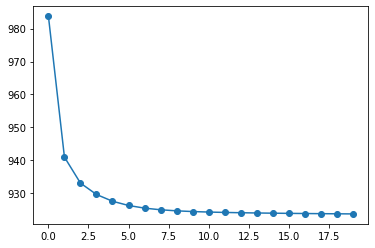

In [20]:
plt.plot(l_loss, 'o-');

## in a function

In [21]:
def als(R, lambda_, dim_factors, n_iter):
    n_u, n_v = R.shape
    U = np.random.rand(n_u, dim_factors)
    V = np.random.rand(dim_factors, n_v)
    M = ~np.isnan(R)
    
    iter_losses = []
    for i_iter in range(n_iter):
        for i in range(n_u):       
            obs = M[i] 
            U[i] = np.array((V[:,obs] @ R[i,obs]).T @ \
                            np.linalg.inv((V @ V.T) + (lambda_ * np.eye(dim_factors))))
        for j in range(n_v):
            obs = M[:, j]
            V[:,j] = np.array((U.T[:, obs] @ R[obs,j]) @ \
                              np.linalg.inv((U.T @ U) + (lambda_ * np.eye(dim_factors))))
        iter_losses.append(loss(R, U, V, M))
    return U,V,iter_losses

## comparing incremental factor dimensions

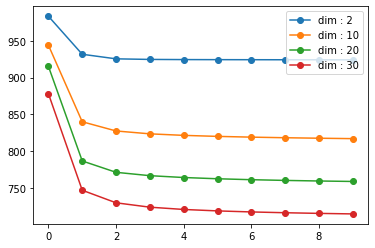

In [22]:
dims = [2, 10, 20, 30]
for dim in dims:
    _, _, losses = als(R, 0.1, dim, 10)
    plt.plot(losses, 'o-', label=f"dim : {dim}")

plt.legend(loc='best')
plt.show()

## comparing incremental regularization rate

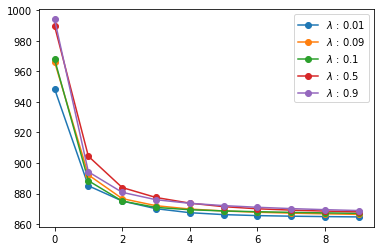

In [23]:
lambdas_ = [0.01, 0.09, 0.1, 0.5, 0.9]
for reg in lambdas_:
    _, _, losses = als(R, reg, 5, 10)
    plt.plot(losses, 'o-', label=f"$\lambda$ : {reg}")

plt.legend(loc='best')
plt.show()

# Weighted Alternating Least Squares (WALS)

\begin{align}
\sum_{i,j \in obs} (A_{ij} - U_i V_j)^2 + w_k \times \sum_{i,j \notin obs} (0 - U_i V_j)^2
\end{align}